# Loading Occupancy Grid Map (OGM)
* Load map
* Perform morphological opening
* Print image before and after morphological opening

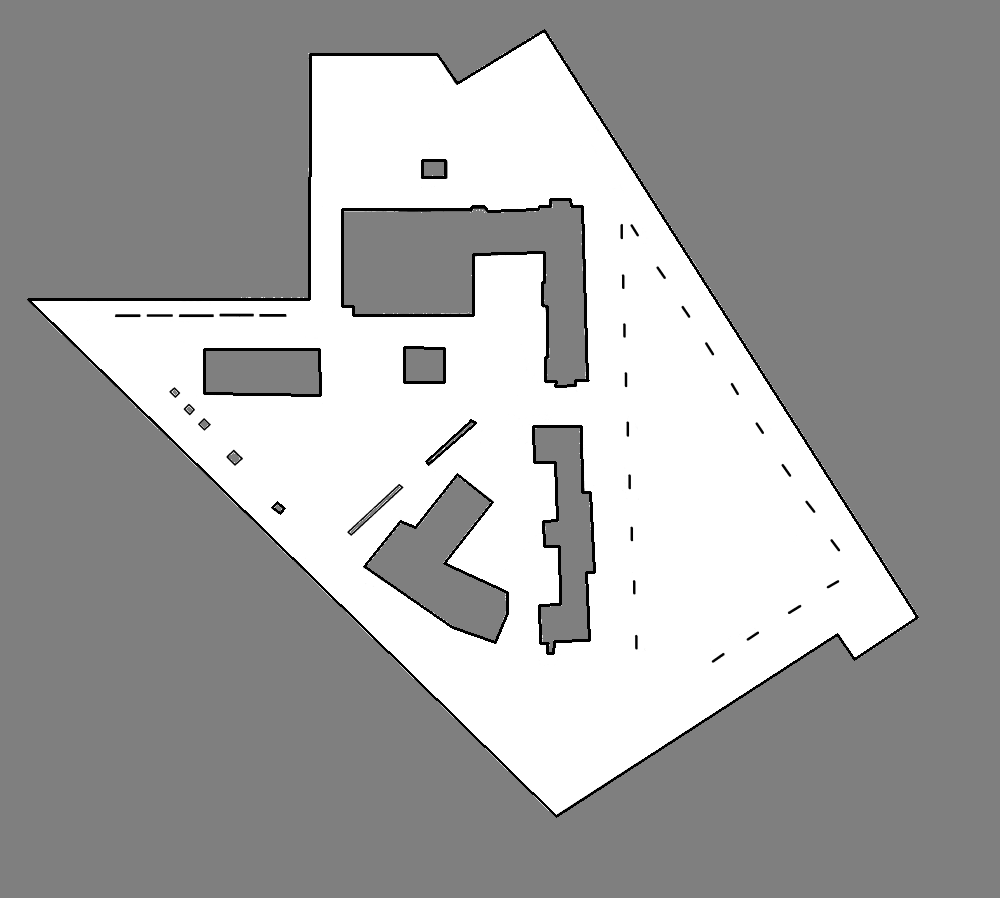

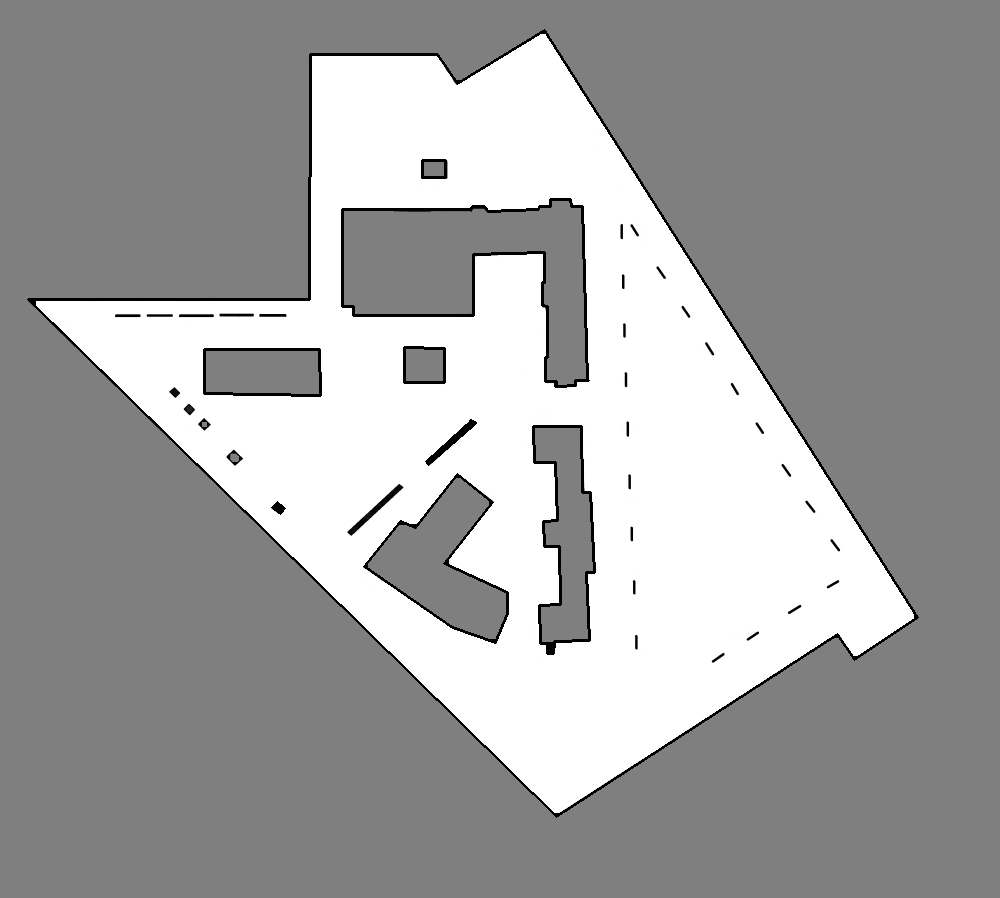

(898, 1000)


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
import numpy as np

image = io.imread('https://raw.githubusercontent.com/stdr-simulator-ros-pkg/stdr_simulator/indigo-devel/stdr_resources/maps/frieburg.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # grayscaling image
cv2_imshow(image)
kernel = np.ones((5,5),np.uint8)
image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel) # morphological opening
cv2_imshow(image)
print(image.shape)

# Performing BrushFire

* Print the brushfire value field of the OGM assuming that:
  - It only applies on free space
  - It starts from the obstacles and spreads to free space
  - It terminates when no further spreading is available

Iteration: 1 
Iteration: 2 
Iteration: 3 
Iteration: 4 
Iteration: 5 
Iteration: 6 
Iteration: 7 
Iteration: 8 
Iteration: 9 
Iteration: 10 
Iteration: 11 
Iteration: 12 
Iteration: 13 
Iteration: 14 


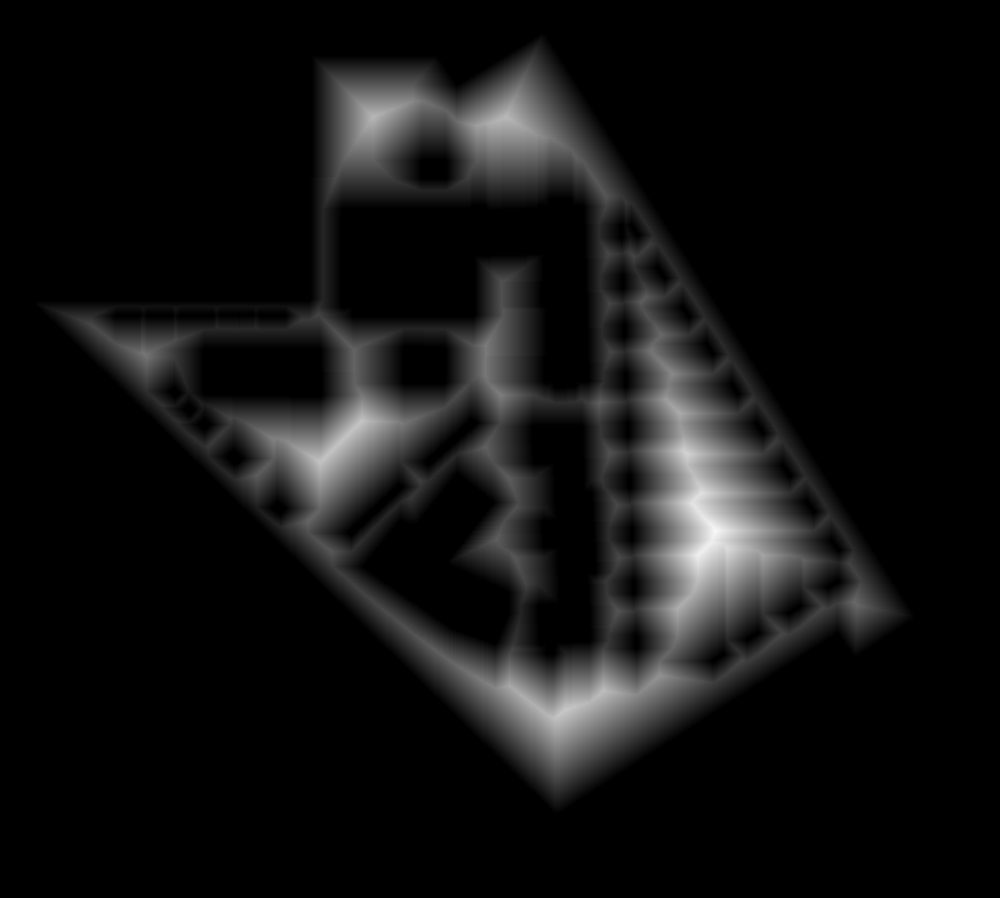

In [ ]:

thr,bith=cv2.threshold(image,127,255,cv2.THRESH_BINARY) # binary threshold

changing=True
iter=0
while changing==True:
  prev=np.copy(bith)
  # spreading from first row to the left
  for row in range(bith.shape[0]):
    for col in range(bith.shape[1]):
      pixel=bith[row,col]
      if pixel==255:
        continue
      else:
        if row==0:
          n1=pixel
          n2=bith[row-1,col]
        elif row==(bith.shape[0]-1):
          n1=bith[row-1,col]
          n2=pixel
        else:
          n1=bith[row-1,col]
          n2=bith[row+1,col]

        if col==0:
          n3=pixel
          n4=bith[row,col+1]
        elif col==(bith.shape[1]-1):
          n3=bith[row,col-1]
          n4=pixel
        else:
          n3=bith[row,col-1]
          n4=bith[row,col+1]

        neighbor=[n1,n2,n3,n4]
        for i in range(len(neighbor)):
          if neighbor[i]>pixel:
            neighbor[i]=pixel+3
          else:
            continue
        if row==0:
          bith[row-1,col]=neighbor[1]
        elif row==(bith.shape[0]-1):
          bith[row-1,col]=neighbor[0]
        else:
          bith[row-1,col]=neighbor[0]
          bith[row+1,col]=neighbor[1]

        if col==0:
          bith[row,col+1]=neighbor[3]
        elif col==(bith.shape[1]-1):
          bith[row,col-1]=neighbor[2]
        else:
          bith[row,col-1]=neighbor[2]
          bith[row,col+1]=neighbor[3]

  # spreading from last row to the right
  for row in range(bith.shape[0]-1,-1,-1):
    for col in range(bith.shape[1]-1,-1,-1):
      pixel=bith[row,col]
      if pixel==255:
        continue
      else:
        if row==0:
          n1=pixel
          n2=bith[row-1,col]
        elif row==(bith.shape[0]-1):
          n1=bith[row-1,col]
          n2=pixel
        else:
          n1=bith[row-1,col]
          n2=bith[row+1,col]

        if col==0:
          n3=pixel
          n4=bith[row,col+1]
        elif col==(bith.shape[1]-1):
          n3=bith[row,col-1]
          n4=pixel
        else:
          n3=bith[row,col-1]
          n4=bith[row,col+1]

        neighbor=[n1,n2,n3,n4]
        for i in range(len(neighbor)):
          if neighbor[i]>pixel:
            neighbor[i]=pixel+2
          else:
            continue
        if row==0:
          bith[row-1,col]=neighbor[1]
        elif row==(bith.shape[0]-1):
          bith[row-1,col]=neighbor[0]
        else:
          bith[row-1,col]=neighbor[0]
          bith[row+1,col]=neighbor[1]

        if col==0:
          bith[row,col+1]=neighbor[3]
        elif col==(bith.shape[1]-1):
          bith[row,col-1]=neighbor[2]
        else:
          bith[row,col-1]=neighbor[2]
          bith[row,col+1]=neighbor[3]

  iter=iter+1
  print(f"Iteration: {iter} ")
  if (prev==bith).all() or iter==50:
    changing=False

cv2_imshow(bith)




# Perform Uniform Probabilistic RoadMap (PRM)
* Perform uniform sampling
* Create a graph connecting all the neighboring nodes (within a distance) with edges that don't cross any obsacles
* Print the graph on the OGM

In [ ]:
class Node:
    def __init__(self, id):
        self.id = id
        self.x = None
        self.y = None
        self.neighbors = []  # list of ids

    def __lt__(self, other):
        # Compare nodes based on their IDs
        return self.id < other.id

class Graph:
  def __init__(self):
    self.nodes = [] # list of Node instances

  def get_node(self, node_id):
      # Retrieve a node from the graph based on its ID
      for node in self.nodes:
          if node.id == node_id:
              return node
      return None

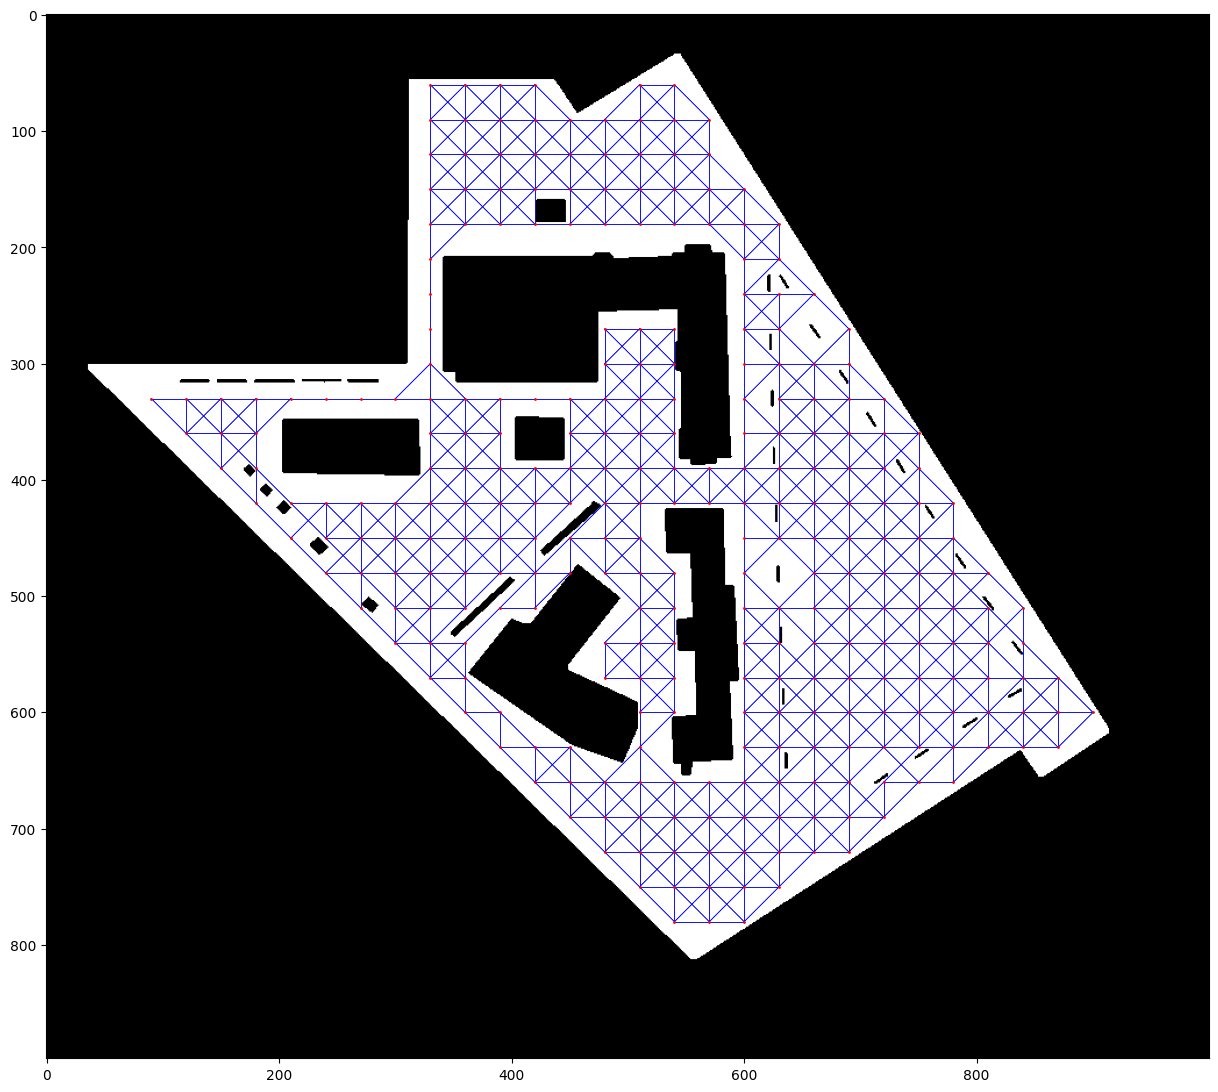

In [ ]:
# Uniform PRM
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


thr,bith=cv2.threshold(image,127,255,cv2.THRESH_BINARY) # binary threshold

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Generate a random point in the free space
def random_point(map):
    while True:
        x = np.random.randint(0, map.shape[0])
        y = np.random.randint(0, map.shape[1])
        if map[x][y] == 255:
            return (x, y)

# Check if a straight-line path between two points is collision-free
def is_path_clear(map, p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1

    # Initialize the error term
    err = dx - dy

    # Initialize the current position
    x, y = x1, y1

    # Create a list of points along the line
    points = [(x, y)]

    # Iterate over the line
    while x != x2 or y != y2:
        # Calculate the error term for the next point
        e2 = 2 * err

        # Determine which direction to move in
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy

        # Add the next point to the list
        points.append((x, y))
    for item in points:
      if map[item] == 0:
        return False
    return True

# Generate a probabilistic roadmap with uniform sampling
def generate_roadmap(map, gap, max_dist):
    x,y = map.shape
    nodes = []
    counter = 0
    # Generate random points in the free space
    for i in range(0,x,gap):
      for j in range(0,y,gap):
        if map[i,j] == 255:
          new_node = Node(counter)
          new_node.x = i
          new_node.y = j
          nodes.append(new_node)
          counter = counter + 1
    # Connect nodes with straight-line paths
    for i in range(0,len(nodes)):
        for j in range(i+1, len(nodes)):
            if is_path_clear(map, (nodes[i].x,nodes[i].y), (nodes[j].x,nodes[j].y)):
                dist = np.linalg.norm(np.array((nodes[i].x,nodes[i].y))-np.array((nodes[j].x,nodes[j].y)))
                if dist <= max_dist:
                    nodes[i].neighbors.append(nodes[j].id)
                    nodes[j].neighbors.append(nodes[i].id)
    return nodes

# Generate a probabilistic roadmap with uniform samples and maximum distance of 50 pixels
gap=30
max_dist=(2*gap**2)**(1/2)
nodes = generate_roadmap(bith, gap, max_dist)

graph = Graph()
graph.nodes = nodes

# Plot the map and the roadmap
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(bith, cmap='gray')
for node in nodes:
  for neighbor_id in node.neighbors:
    neighbor = [neighbor for neighbor in nodes if neighbor.id == neighbor_id]
    plt.plot([node.y, neighbor[0].y], [node.x, neighbor[0].x], 'b-', linewidth=0.5)
plt.plot([p.y for p in nodes], [p.x for p in nodes], 'r.', markersize=2)
plt.show()


# Perform Random Probabilistic RoadMap (PRM)
* Perform random sampling
* Create a graph connecting all the neighboring nodes (within a distance) with edges that don't cross any obsacles
* Print the graph on the OGM


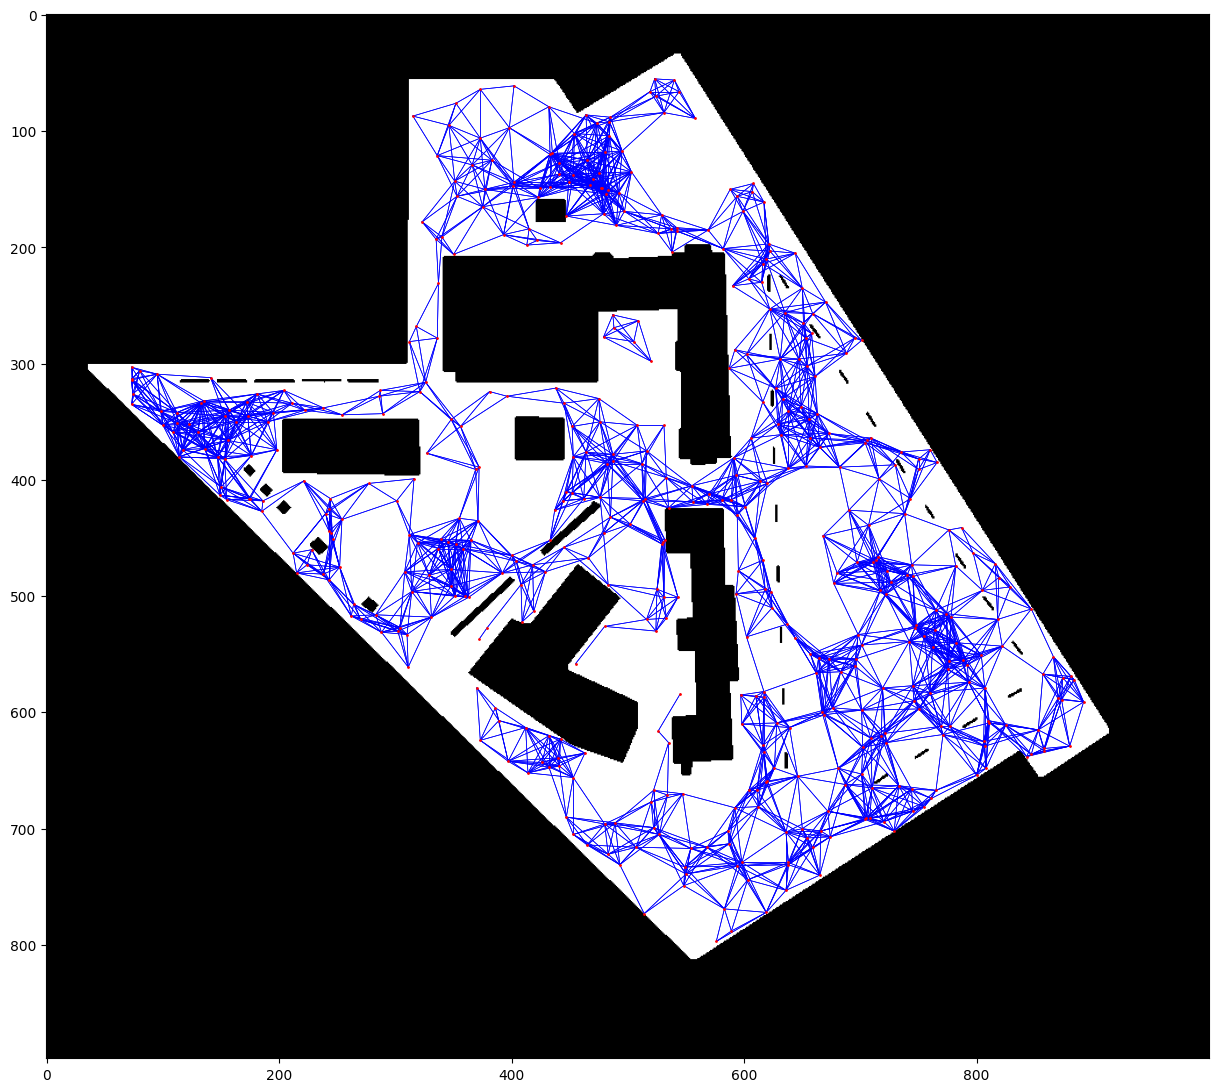

In [ ]:
# Random PRM
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

thr,bith=cv2.threshold(image,127,255,cv2.THRESH_BINARY) # binary threshold

# Generate a random point in the free space
def random_point(map,nodes):
    while True:
        x = np.random.randint(0, map.shape[0])
        y = np.random.randint(0, map.shape[1])
        if map[x][y] == 255:
          if not any(node.x == x for node in nodes) or not any(node.y == y for node in nodes):
            return (x, y)

# Check if a straight-line path between two points is collision-free
def is_path_clear(map, p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1

    # Initialize the error term
    err = dx - dy

    # Initialize the current position
    x, y = x1, y1

    # Create a list of points along the line
    points = [(x, y)]

    # Iterate over the line
    while x != x2 or y != y2:
        # Calculate the error term for the next point
        e2 = 2 * err

        # Determine which direction to move in
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy

        # Add the next point to the list
        points.append((x, y))
    for item in points:
      if map[item] == 0:
        return False
    return True

# Generate a probabilistic roadmap with random sampling
def generate_roadmap(map, num_samples, max_dist):
    nodes = []
    # Generate random points in the free space
    for i in range(num_samples):
        p = random_point(map,nodes)
        new_node = Node(i)
        new_node.x = p[0]
        new_node.y = p[1]
        nodes.append(new_node)
    # Connect nodes with straight-line paths
    for i in range(num_samples):
        for j in range(i+1, num_samples):
            if is_path_clear(map, (nodes[i].x,nodes[i].y), (nodes[j].x,nodes[j].y)):
                dist = np.linalg.norm(np.array((nodes[i].x,nodes[i].y))-np.array((nodes[j].x,nodes[j].y)))
                if dist <= max_dist:
                    nodes[i].neighbors.append(nodes[j].id)
                    nodes[j].neighbors.append(nodes[i].id)
    return nodes

# Generate a probabilistic roadmap with x samples and maximum distance of 50 pixels
nodes = generate_roadmap(bith, 500, 50)

graph = Graph()
graph.nodes = nodes

# Plot the map and the roadmap
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(bith, cmap='gray')
for node in nodes:
  for neighbor_id in node.neighbors:
    neighbor = [neighbor for neighbor in nodes if neighbor.id == neighbor_id]
    plt.plot([node.y, neighbor[0].y], [node.x, neighbor[0].x], 'b-', linewidth=0.5)
plt.plot([p.y for p in nodes], [p.x for p in nodes], 'r.', markersize=2)
plt.show()



# Dijkstra's Algorithm
* Set a starting and finishing node
* Perform Dijkstra's Algorithm on the graph
* Terminate when destination is reached
* Plot Dijkstra's path and its spreading (and mark the starting and the finishing points)

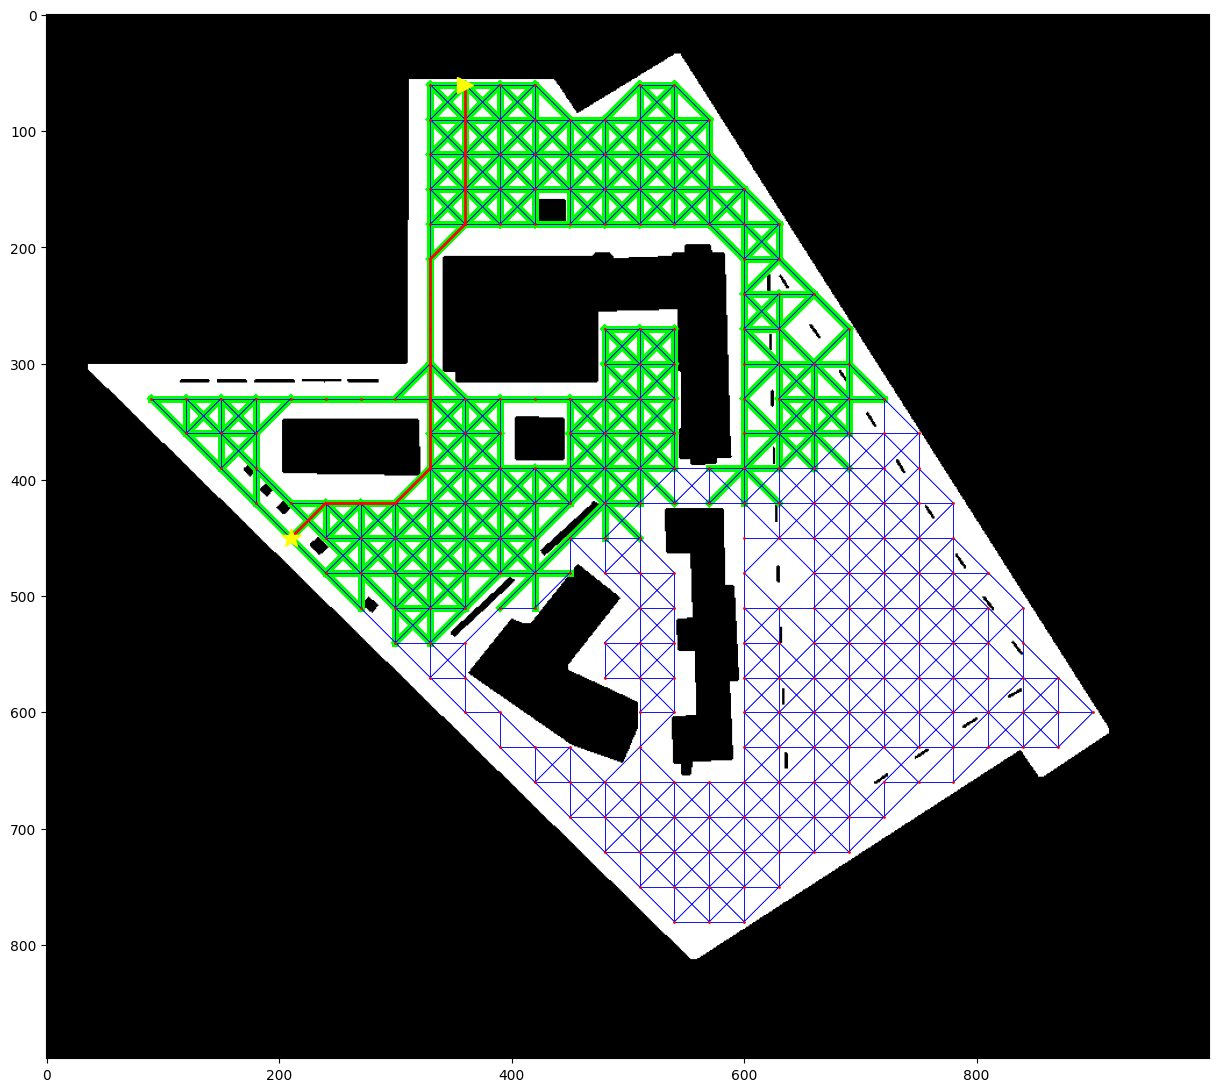

In [ ]:
# Dijkstra


import heapq

# Set a starting and a destination node id (must be int)
start=1
destination=142

def dijkstra(graph, start_id, end_id):
    # Retrieve the start and end nodes from the graph
    start_node = None
    end_node = None
    for node in graph.nodes:
        if node.id == start_id:
            start_node = node
        elif node.id == end_id:
            end_node = node
        if start_node and end_node:
            break

    if not start_node or not end_node:
        raise ValueError("Start or end node not found in the graph.")

    # Initialize distances and predecessors
    distances = {node: float('inf') for node in graph.nodes}
    distances[start_node] = 0
    predecessors = {node: None for node in graph.nodes}

    # Priority queue to store nodes and their distances
    pq = [(0, start_node)]

    # Create a list to keep track of visited nodes
    visited_nodes=[]

    while pq:
        current_distance, current_node = heapq.heappop(pq)
        visited_nodes.append(current_node)

        # Break the loop if the end node is reached
        if current_node == end_node:
            break

        # Skip if the current distance is greater than the recorded distance
        if current_distance > distances[current_node]:
            continue

        # Explore neighbors
        for neighbor_id in current_node.neighbors:
            neighbor = None
            for node in graph.nodes:
                if node.id == neighbor_id:
                    neighbor = node
                    break

            if not neighbor:
                continue

            # Calculate the new distance to the neighbor
            new_distance = current_distance + distance(current_node, neighbor)

            # Update the distance and predecessor if a shorter path is found
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                predecessors[neighbor] = current_node
                heapq.heappush(pq, (new_distance, neighbor))

    # Reconstruct the shortest path
    path = []
    current = end_node
    while current:
        path.append(current)
        current = predecessors[current]
    path.reverse()

    return path, visited_nodes


def distance(node1, node2):
    # Calculate the Euclidean distance between two nodes (assumes node positions are known)
    dx = node1.x - node2.x
    dy = node1.y - node2.y
    return (dx ** 2 + dy ** 2) ** 0.5


path = dijkstra(graph, start, destination)[0]
visited_nodes=dijkstra(graph, start, destination)[1]

# Plot the map and the roadmap
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(bith, cmap='gray')

# Plot the roadmap edges
for node in nodes:
    for neighbor_id in node.neighbors:
        neighbor = [neighbor for neighbor in nodes if neighbor.id == neighbor_id]
        plt.plot([node.y, neighbor[0].y], [node.x, neighbor[0].x], 'b-', linewidth=0.5)

# Plot the roadmap nodes
plt.plot([p.y for p in nodes], [p.x for p in nodes], 'r.', markersize=2)

# Plot Dijkstra's spreading
for node in visited_nodes[0:-1]:
  for neighbor_id in node.neighbors:
        neighbor = [neighbor for neighbor in nodes if neighbor.id == neighbor_id]
        plt.plot([node.y, neighbor[0].y], [node.x, neighbor[0].x], 'lime', linewidth=5, alpha=1,zorder=1)

# Plot the Dijkstra's shortest path
for i in range(len(path) - 1):
    node1 = path[i]
    node2 = path[i + 1]
    plt.plot([node1.y, node2.y], [node1.x, node2.x], 'red', linewidth=2)

# Mark start and destination
plt.plot(nodes[start].y,nodes[start].x,'yellow',marker=">", markersize=12)
plt.plot(nodes[destination].y,nodes[destination].x,'yellow',marker="*", markersize=15)

plt.show()

# A* Algorithm
* Set a starting and finishing node
* Perform A* on the graph
* Terminate when destination is reached
* Plot A* path and its spreading (and mark the starting and the finishing points)

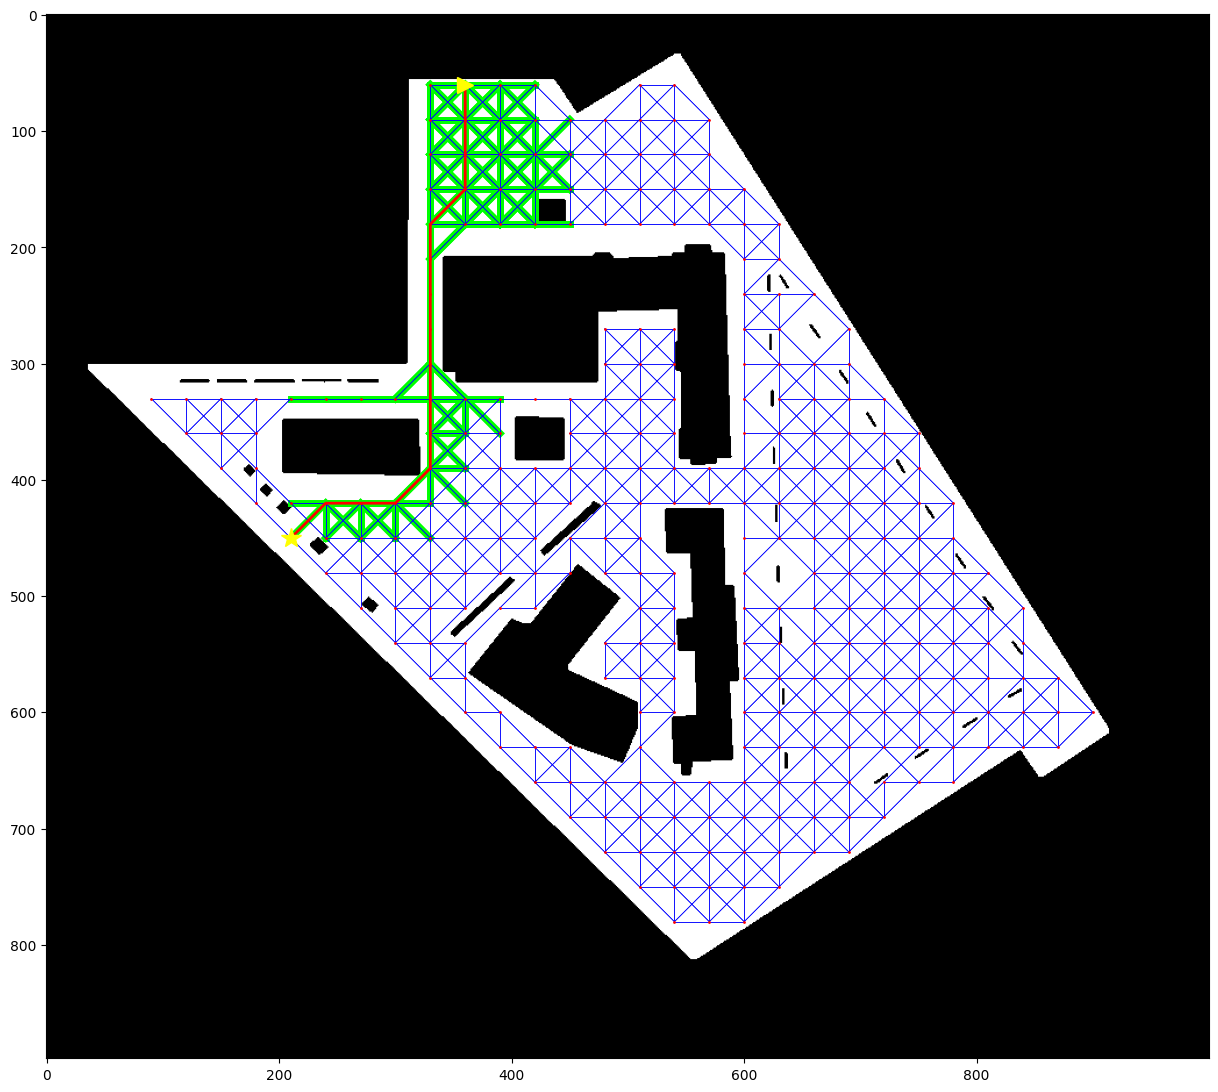

In [ ]:
# A*

import heapq

# Set a starting and a destination node id (must be int)
start=start
destination=destination

# Create a list to keep track of visited nodes
visited_nodes=[]

def heuristic(node, goal_node):
    # Calculate the Euclidean distance between two nodes as the heuristic
    dx = node.x - goal_node.x
    dy = node.y - goal_node.y
    return (dx ** 2 + dy ** 2) ** 0.5

def astar(graph, start_id, goal_id):
    start_node = graph.get_node(start_id)
    goal_node = graph.get_node(goal_id)

    if start_node is None or goal_node is None:
        return None

    open_set = []
    closed_set = set()
    came_from = {}
    g_score = {node: float('inf') for node in graph.nodes}
    g_score[start_node] = 0
    f_score = {node: float('inf') for node in graph.nodes}
    f_score[start_node] = heuristic(start_node, goal_node)

    heapq.heappush(open_set, (f_score[start_node], start_node))

    # Update visited_nodes globally
    global visited_nodes

    while open_set:
        _, current_node = heapq.heappop(open_set)
        visited_nodes.append(current_node)

        if current_node == goal_node:
            return reconstruct_path(came_from, goal_node)

        closed_set.add(current_node)

        for neighbor_id in current_node.neighbors:
            neighbor = graph.get_node(neighbor_id)
            if neighbor in closed_set:
                continue

            tentative_g_score = g_score[current_node] + heuristic(current_node, neighbor)

            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current_node
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal_node)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
    return None

def reconstruct_path(came_from, current_node):
    path = [current_node]
    while current_node in came_from:
        current_node = came_from[current_node]
        path.insert(0, current_node)
    return path

# Usage example
path = astar(graph, start, destination)

# Plot the map and the roadmap
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(bith, cmap='gray')
for node in nodes:
    for neighbor_id in node.neighbors:
        neighbor = [neighbor for neighbor in nodes if neighbor.id == neighbor_id]
        plt.plot([node.y, neighbor[0].y], [node.x, neighbor[0].x], 'b-', linewidth=0.5)
plt.plot([p.y for p in nodes], [p.x for p in nodes], 'r.', markersize=2)

# Plot A*'s spreading
for node in visited_nodes[0:-1]:
  for neighbor_id in node.neighbors:
        neighbor = [neighbor for neighbor in nodes if neighbor.id == neighbor_id]
        plt.plot([node.y, neighbor[0].y], [node.x, neighbor[0].x], 'lime', linewidth=5, alpha=1,zorder=1)

# Plot the A* path if it exists
if path:
    path_x = [node.y for node in path]
    path_y = [node.x for node in path]
    plt.plot(path_x, path_y, 'red', linewidth=2)

# Mark start and destination
plt.plot(nodes[start].y,nodes[start].x,'yellow',marker=">", markersize=12)
plt.plot(nodes[destination].y,nodes[destination].x,'yellow',marker="*", markersize=15)

plt.show()


# Rapidly-exploring Random Tree (RRT)
* Set a starting and a finishing point
* Perform RRT, starting the spreading from the starting point
* Terminate the exploration when destination is reached
* Plot the tree and the path on the OGM (and mark the starting and the finishing points)

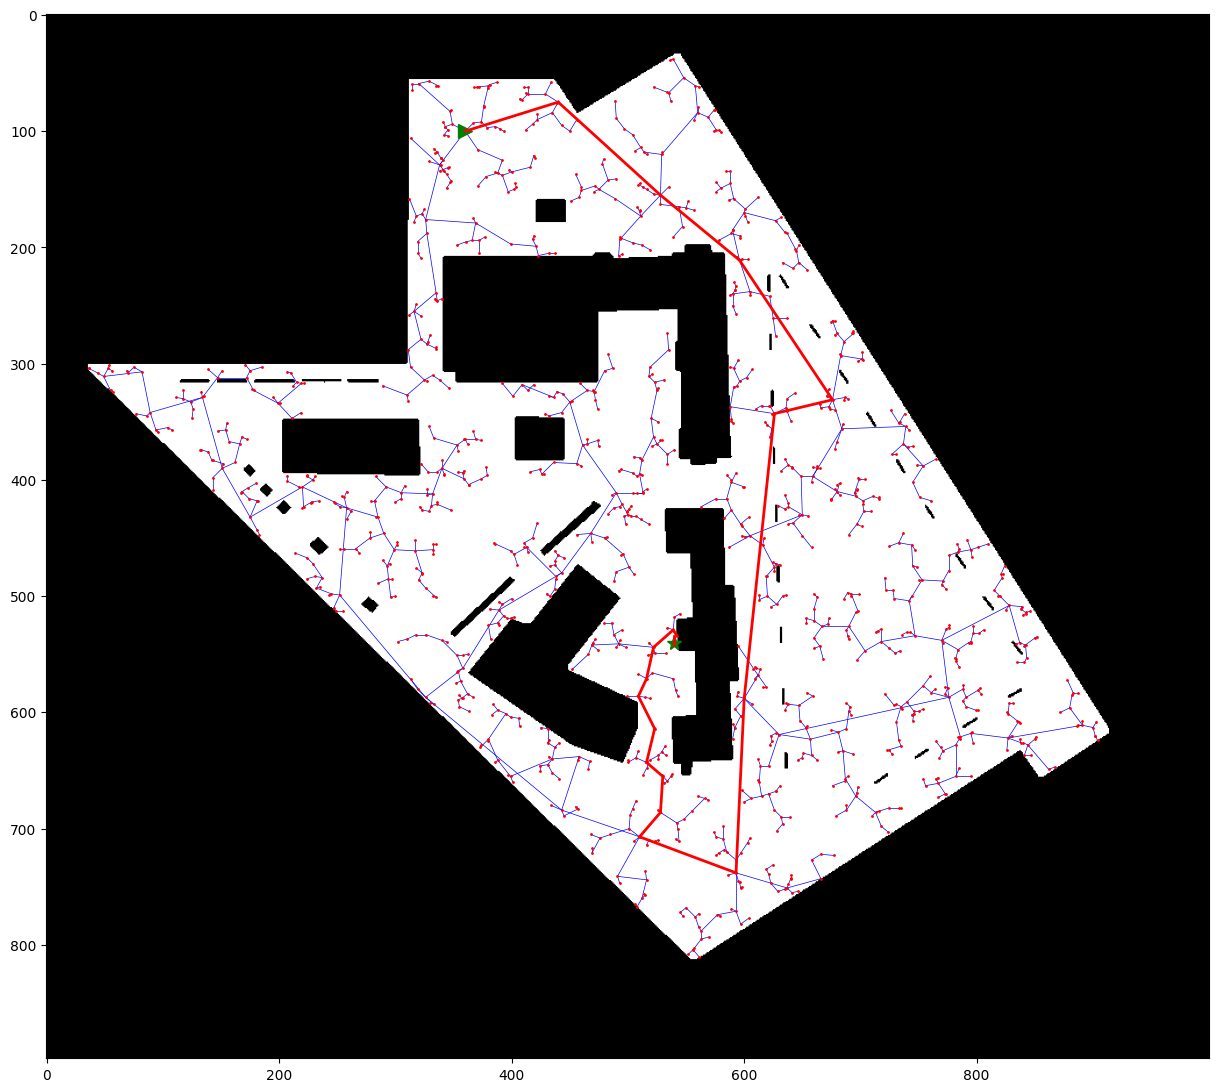

In [ ]:
height, width = bith.shape
graph = Graph()

def get_delta_point(point1, point2, middle):
    x1, y1 = point1
    x2, y2 = point2
    middle_x = (x1 + x2) // middle
    middle_y = (y1 + y2) // middle
    delta_point = (middle_x, middle_y)
    return delta_point

def add_node(x, y):
    new_id = len(graph.nodes)
    new_node = Node(new_id)
    new_node.x = x
    new_node.y = y
    graph.nodes.append(new_node)
    return new_node

def get_nearest_node(point):
    distances = np.linalg.norm(np.array([(node.x, node.y) for node in graph.nodes]) - np.array(point), axis=1)
    nearest_index = np.argmin(distances)
    return graph.nodes[nearest_index]

def close_to_endpoint(point1, point2, threshold):
    distance = np.linalg.norm(np.array(point1) - np.array(point2))
    return distance < threshold

def get_random_point(width,height):
    x = np.random.randint(0, height-1)
    y = np.random.randint(0, width-1)
    return (x, y)

def is_path_clear(map, p1, p2):
      #print("p1")
      #print(p1[0],p1[1])
      #print("p2")
      #print(p2[0],p2[1])
      x1, y1 = p1
      x2, y2 = p2
      dx = abs(x2 - x1)
      dy = abs(y2 - y1)
      sx = 1 if x1 < x2 else -1
      sy = 1 if y1 < y2 else -1

      # Initialize the error term
      err = dx - dy

      # Initialize the current position
      x, y = x1, y1

      # Create a list of points along the line
      points = [(x, y)]

      # Iterate over the line
      while x != x2 or y != y2:
          # Calculate the error term for the next point
          e2 = 2 * err

          # Determine which direction to move in
          if e2 > -dy:
              err -= dy
              x += sx
          if e2 < dx:
              err += dx
              y += sy

          # Add the next point to the list
          points.append((x, y))
      for item in points:
        if map[item] == 0:
          return False
      return True

def rrt(image, start_node, end_node, delta):
    path_found = False

    graph.nodes.append(start_node)

    while not path_found:
      new_candidate = get_random_point(width,height)
      neighbor = get_nearest_node(new_candidate)
      #print("new_candidate x"+str(new_candidate[0])+" / new_candidate y"+str(new_candidate[1]))
      #print("neighbor x"+str(neighbor.x)+" / neighbor y"+str(neighbor.y))
      new_candidate = get_delta_point((neighbor.x,neighbor.y),new_candidate,2)                    #Just divide by 2 to get the middle between the 2 points
      if(is_path_clear(image,new_candidate,(neighbor.x,neighbor.y))):
        add_node(new_candidate[0],new_candidate[1])
        graph.get_node(len(graph.nodes)-1).neighbors.append(neighbor.id)
        #neighbor.neighbors.append(graph.get_node(len(graph.nodes)-1).id)
        #graph.get_node(len(graph.nodes)-1).neighbors.append(neighbor.id)
        if close_to_endpoint((end_node.x,end_node.y),(new_candidate[0],new_candidate[1]),delta):
          path_found=True
          return graph


start_node = Node(1)
start_node.x = 100
start_node.y = 360
graph.nodes.append(start_node)

end_node = Node(2)
end_node.x = 540
end_node.y = 540


graph = rrt(bith, start_node, end_node, 10)                   #if you find a node with distance less than 10 with the end_node then finish execution

nodes = graph.nodes

# Extract path from the tree
prev_node=graph.get_node(len(graph.nodes)-1).id
tree_path=[prev_node]
while graph.get_node(prev_node).neighbors:
    prev_node=graph.get_node(prev_node).neighbors[0]
    tree_path.append(prev_node)


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(bith, cmap='gray')
for node in graph.nodes:
  for neighbor_id in node.neighbors:
    neighbor = graph.get_node(neighbor_id)
    #neighbor = [neighbor for neighbor in graph.nodes if neighbor.id == neighbor_id]
    plt.plot([node.y, neighbor.y], [node.x, neighbor.x], 'b-', linewidth=0.5)
plt.plot([p.y for p in graph.nodes], [p.x for p in graph.nodes], 'r.', markersize=2)
plt.plot(start_node.y,start_node.x,'green',marker=">", markersize=10)
plt.plot(end_node.y,end_node.x,'green',marker="*", markersize=10)

# Plot path
for node in range(len(tree_path)-1):
    plt.plot([graph.get_node(tree_path[node]).y,graph.get_node(tree_path[node+1]).y],[graph.get_node(tree_path[node]).x,graph.get_node(tree_path[node+1]).x],'red',linewidth=2)
if is_path_clear(bith,(end_node.x,end_node.y),(graph.get_node(len(graph.nodes)-1).x,graph.get_node(len(graph.nodes)-1).y)):
  plt.plot([end_node.x,end_node.y],[graph.get_node(len(graph.nodes)-1).x,graph.get_node(len(graph.nodes)-1).y],'red',linewidth=2)

plt.show()

# RRT*
* Set a starting and a finishing point
* Perform RRT*, starting the spreading from the starting point
* Terminate the exploration when destination is reached
* Plot the tree and the path on the OGM (and mark the starting and the finishing points)

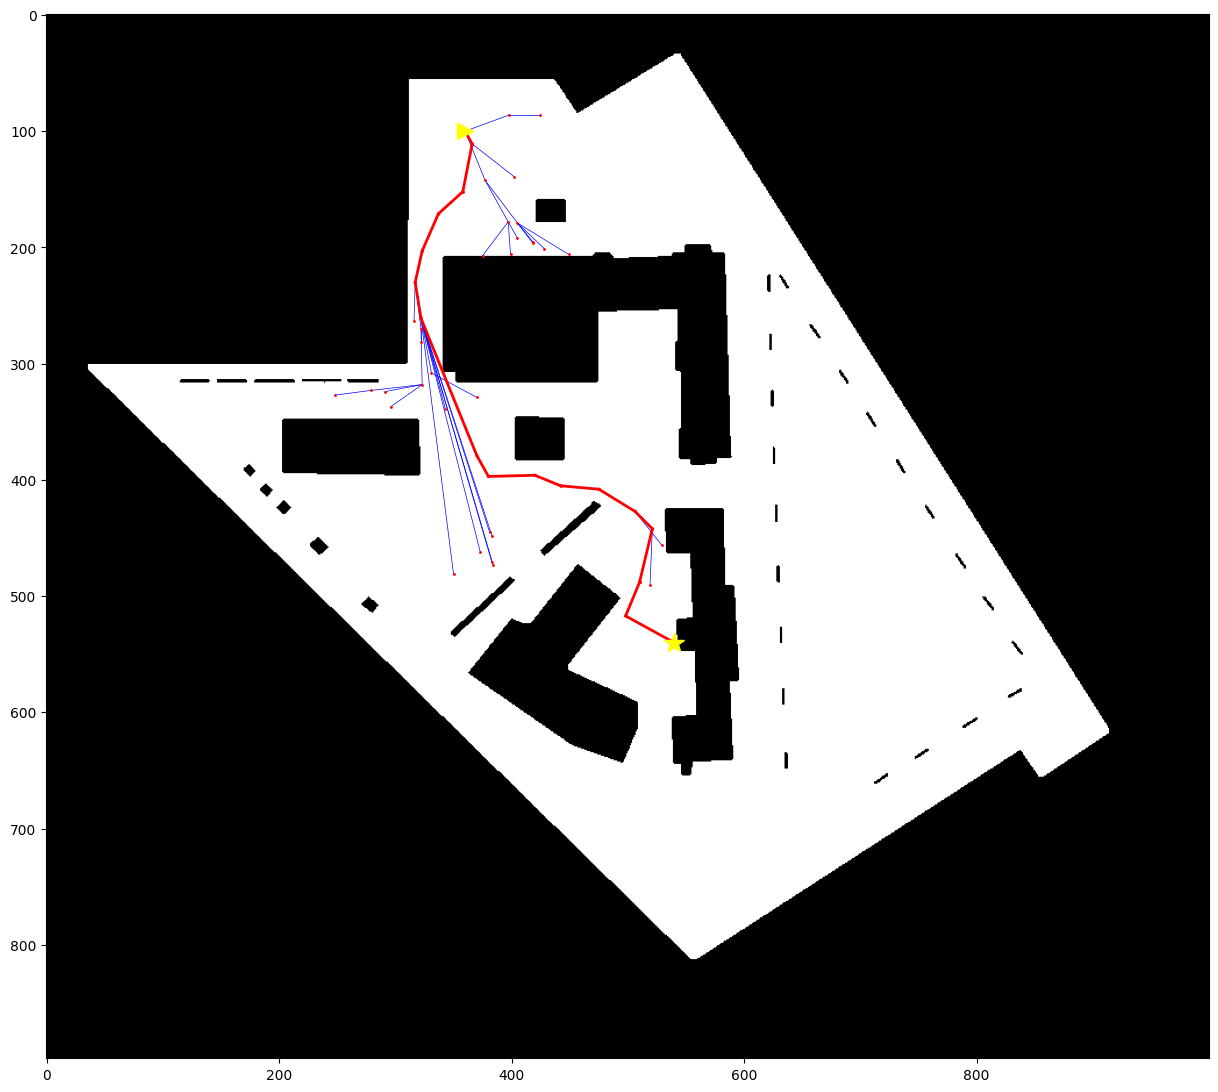

In [ ]:
# RRT*
import random
import math

# Check if a straight-line path between two points is collision-free
def is_path_clear(map, p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1

    # Initialize the error term
    err = dx - dy

    # Initialize the current position
    x, y = x1, y1

    # Create a list of points along the line
    points = [(x, y)]

    # Iterate over the line
    while x != x2 or y != y2:
        # Calculate the error term for the next point
        e2 = 2 * err

        # Determine which direction to move in
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy

        # Add the next point to the list
        points.append((x, y))
    for item in points:
      if map[item] == 0:
        return False
    return True

def rrtstar_algorithm(start_node, goal_node, map):
    max_iterations = 1000
    max_step_size = 50
    counter=0
    iter=0

    width, height = map.shape

    # Check if a given point is valid (i.e., lies within the image bounds and is not an obstacle)
    def is_valid_point(x, y, map):
        if x < 0 or x >= width or y < 0 or y >= height or map[x,y]==0:
            return False
        return True

    # Calculate Euclidean distance between two points
    def euclidean_distance(x1, y1, x2, y2):
        return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

    # Generate a random valid point within the image bounds
    def generate_random_point():
        x = random.randint(0, width - 1)
        y = random.randint(0, height - 1)
        while not is_valid_point(x, y, map):
            x = random.randint(0, width - 1)
            y = random.randint(0, height - 1)
        return x, y

    # Find the nearest node in the RRT tree to a given point
    def find_nearest_node(point, nodes):
        nearest_node = None
        min_distance = float('inf')
        for node in nodes:
            distance = euclidean_distance(node.x, node.y, point[0], point[1])
            if distance < min_distance:
                nearest_node = node
                min_distance = distance
        return nearest_node

    def link(nearest_node,point,max_step_size=max_step_size):
      distance = euclidean_distance(nearest_node.x, nearest_node.y, point[0], point[1])
      if distance <= max_step_size and is_path_clear(map,[nearest_node.x,nearest_node.y], point):
          return point
      else:
          global step_size
          step_size=random.randint(1,max_step_size)
          theta = math.atan2(point[1] - nearest_node.y, point[0] - nearest_node.x)
          x = int(nearest_node.x + step_size * math.cos(theta))
          y = int(nearest_node.y + step_size * math.sin(theta))
          if is_path_clear(map,[nearest_node.x,nearest_node.y], [x,y]):
            return x,y
          else:
            return False,False
    def free_path_to_goal(goal_node,point,prox=max_step_size):
        distance = euclidean_distance(goal_node[0], goal_node[1], point[0], point[1])
        if distance<prox and is_path_clear(map,goal_node,point):
            new_node=Node(counter)
            new_node.x=goal_node[0]
            new_node.y=goal_node[1]
            nodes.append(new_node)
            nodes[counter].neighbors.append(nodes[counter-1].id)
            nodes[counter-1].neighbors.append(nodes[counter].id)
            return nodes
        return False

    nodes=[]
    nodes_cost=[]
    i,j=start_node[0],start_node[1]
    start_node=Node(counter)
    start_node.x = i
    start_node.y = j
    nodes_cost.append(0)

    # Check if input nodes are valid and adding the start_node to the node list
    if is_valid_point(i, j, map):
        nodes.append(start_node)
        counter = counter + 1
    else:
        print('Error: invalid start_node')
        return 0
    if is_valid_point(goal_node[0],goal_node[1],map)==0:
        print('Error: invalid goal_node')
        return 0

    while iter<=max_iterations:
        i,j=generate_random_point()
        point=[i,j]
        nearest_node=find_nearest_node(point,nodes)
        i,j=link(nearest_node,point)
        point=[i,j]
        if i!=False:
            new_node=Node(counter)
            new_node.x=i
            new_node.y=j
            nodes.append(new_node)
            # Calculate cost of the node so far (from the start)
            cost_new=nodes_cost[nearest_node.id]+euclidean_distance(i,j,nearest_node.x,nearest_node.y)
            best_neighbor_id=nearest_node.id  # Temporarily set as best neighbor the nearest
            # Check for a better neighbor according to their cost so far and the distance from current node
            for id in range(len(nodes)-1):
                distance=euclidean_distance(i,j,nodes[id].x,nodes[id].y)
                if is_path_clear(map,[i,j],[nodes[id].x,nodes[id].y]):
                    if distance<max_step_size:
                        current_cost=nodes_cost[id]+distance
                        if current_cost<cost_new:
                            cost_new=current_cost
                            best_neighbor_id=id
            nodes_cost.append(cost_new)
            nodes[counter].neighbors.append(best_neighbor_id)    # Each node is neighbor with his previous node (not mutual)
            counter=counter+1
            # Check if a nodes cost can be reduced by connecting it to the current node (and disconnecting it from its previous neighbor)
            for id in range(len(nodes)-1):
                if is_path_clear(map,[nodes[-1].x,nodes[-1].y],[nodes[id].x,nodes[id].y]):
                    distance=euclidean_distance(nodes[-1].x,nodes[-1].y,nodes[id].x,nodes[id].y)
                    current_cost=nodes_cost[id]
                    possible_cost=nodes_cost[-1]+distance
                    if possible_cost<current_cost:
                        nodes_cost[id]=possible_cost
                        nodes[id].neighbors[0]=nodes[-1].id

        if free_path_to_goal(goal_node,point,prox=max_step_size)!=False:
            #extract_path_from_tree(nodes)
            return nodes
        iter=iter+1
    return nodes,path

start_node=[100,360]
goal_node=[540,540]
map=bith
nodes=rrtstar_algorithm(start_node, goal_node, map)

# Extract path from the tree
prev_node=nodes[-1].id
tree_path=[prev_node]
while prev_node!=0:
    prev_node=nodes[prev_node].neighbors[0]
    tree_path.append(prev_node)

tree = Graph()
tree.nodes = nodes

# Plot the map and the roadmap
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(bith, cmap='gray')
for node in nodes:
  for neighbor_id in node.neighbors:
    neighbor = [neighbor for neighbor in nodes if neighbor.id == neighbor_id]
    plt.plot([node.y, neighbor[0].y], [node.x, neighbor[0].x], 'b-', linewidth=0.5)
plt.plot([p.y for p in nodes], [p.x for p in nodes], 'r.', markersize=2)

# Plot path
for node in range(len(tree_path)-1):
    plt.plot([nodes[tree_path[node]].y,nodes[tree_path[node+1]].y],[nodes[tree_path[node]].x,nodes[tree_path[node+1]].x],'red',linewidth=2)

# Mark start and destination
plt.plot(start_node[1],start_node[0],'yellow',marker=">", markersize=12)
plt.plot(goal_node[1],goal_node[0],'yellow',marker="*", markersize=15)

plt.show()





# Path smoothing
* Creat more points on the path for better path smoothing
* Perform gradient descent to smoothe the path
* If the new path crosses an obstacle keep the initial points at that part of the map
* Print the path before and after path smoothing on the OGM (and mark the starting and the finishing points)

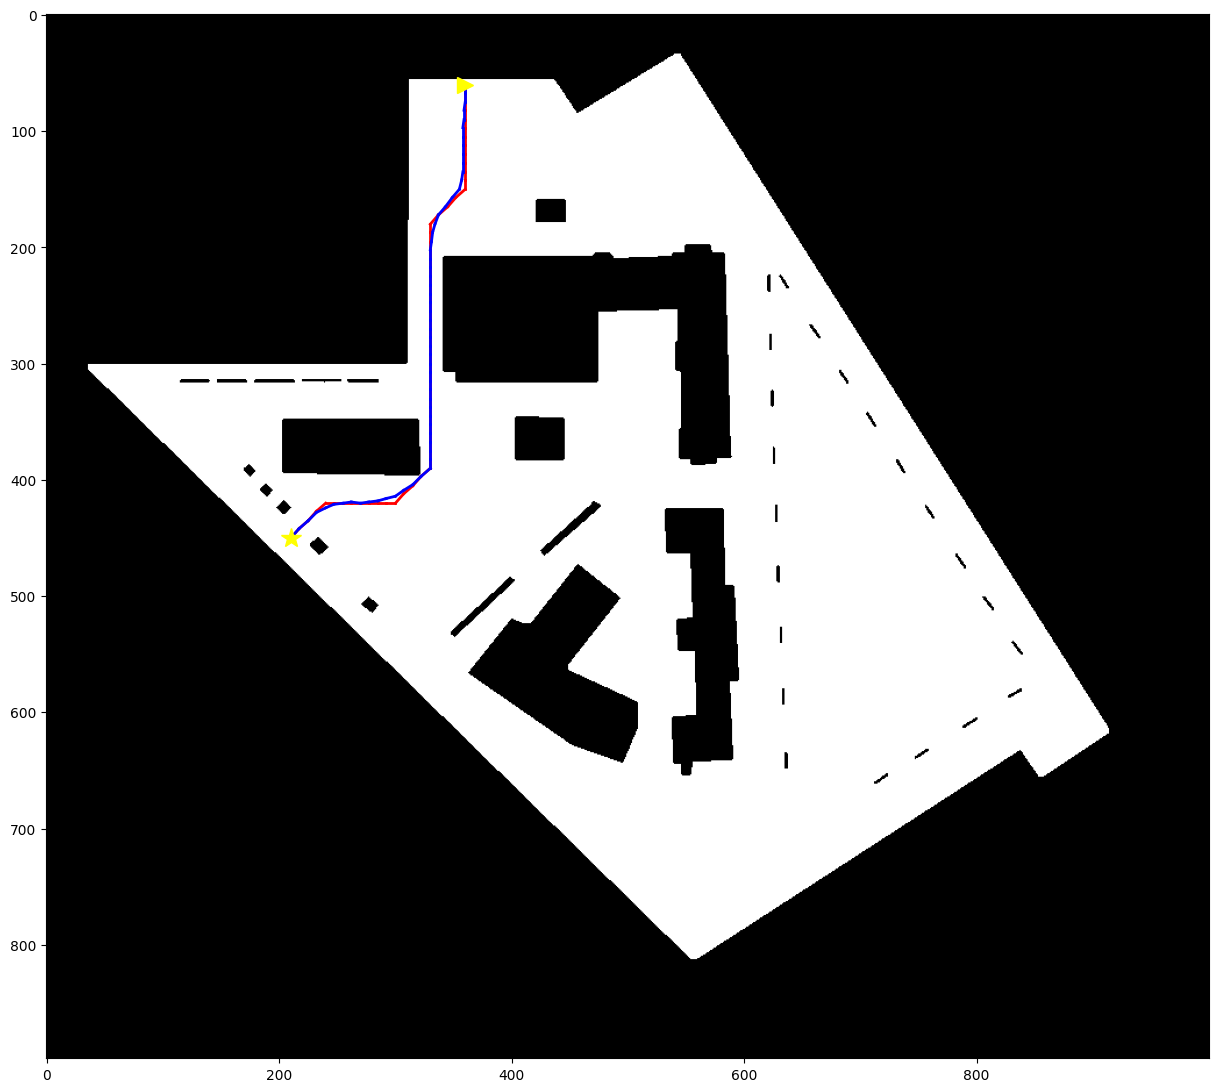

In [ ]:
# Path smoothing (Gradient Descent)

from copy import deepcopy

# Check if a straight-line path between two points is collision-free
def is_path_clear(map, p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1

    # Initialize the error term
    err = dx - dy

    # Initialize the current position
    x, y = x1, y1

    # Create a list of points along the line
    points = [(x, y)]

    # Iterate over the line
    while x != x2 or y != y2:
        # Calculate the error term for the next point
        e2 = 2 * err

        # Determine which direction to move in
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy

        # Add the next point to the list
        points.append((x, y))

    for item in points:
      if map[item]== 0:
        return False
    return True

def path_smoothing(path,a,b,tol,map):

    # path <list>: a list of [x,y] points, the path to be smoothed
    # a <float>: weight for data (larger a gives a path closer to the original)
    # b <float>: weight for smoothing (larger b gives a path much smoother than the original)
    # tol <float>: the minimum changing so the while loop keeps going
    # map <array>: the image of the map to check if collision free path is created

    new_path=deepcopy(path)
    changing=tol
    max_iter=1000
    iter=0
    while changing>=tol or iter<max_iter:
        for i in range(1, len(new_path) - 1):
          changing = 0.0
          for j in range(2):
              x_i=path[i][j]
              y_i, y_prev, y_next = new_path[i][j], new_path[i-1][j], new_path[i+1][j]
              y_i_saved = y_i
              y_i= y_i+a*(x_i-y_i)+b*(y_next+y_prev-(2*y_i))
              new_path[i][j] = int(y_i)
              changing=changing+abs(y_i-y_i_saved)
          # Check if path is clear, we cannot have the robot passing through occupied spaces
          if is_path_clear(map,new_path[i-1],new_path[i])==False:
            new_path[i-1],new_path[i]=deepcopy(path[i-1]),deepcopy(path[i])
            continue
        iter=iter+1
    return new_path

# Converting a list of nodes to list of coordinates
path_coords=[]
for i in range(len(path)):
  coords=[path[i].x,path[i].y]
  path_coords.append(coords)
  # Generating more points along the path for better smoothing
  if i!=len(path)-1:
    quad_x=(path[i+1].x-path[i].x)/4
    quad_y=(path[i+1].y-path[i].y)/4
    for j in range(1,4):
        coords=[int(j*quad_x+path[i].x),int(j*quad_y+path[i].y)]
        path_coords.append(coords)

# Applying smoothing to the path
new_path=path_smoothing(path_coords,0.4,0.7,10,bith)

# Plot the map
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(bith, cmap='gray')

# Plot the old path
for i in range(len(path_coords)-1):
  plt.plot([path_coords[i][1],path_coords[i+1][1]],[path_coords[i][0],path_coords[i+1][0]],'red', linewidth=2)

# Plot the new path
for i in range(len(new_path)-1):
  plt.plot([new_path[i][1],new_path[i+1][1]],[new_path[i][0],new_path[i+1][0]],'blue', linewidth=2)

# Mark start and destination
plt.plot(path_coords[0][1],path_coords[0][0],'yellow',marker=">", markersize=12)
plt.plot(path_coords[-1][1],path_coords[-1][0],'yellow',marker="*", markersize=15)
plt.show()
